In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import MDAnalysis.lib.distances
import nglview as nv

_ColormakerRegistry()

In [2]:
#Path to structure and trajectory files
structf = "/Volumes/Akash_SSD/starter_project/ubiquitin/chestnut/unfold_fold/i-3.5/1/indus_fwd.gro"
trajf = "/Volumes/Akash_SSD/starter_project/ubiquitin/chestnut/unfold_fold/i-3.5/1/indus_fwd_mol.xtc"

#Create universe
u = mda.Universe(structf,trajf)
protein = u.select_atoms("protein")

In [3]:
#Visualize using nglview
nv.show_mdanalysis(protein)

NGLWidget(max_frame=200)

# Ubiquitin - atom selections

In [4]:
print(len(protein))
#GROMACS make_ndx: 1231

1231


In [5]:
protein_heavy = u.select_atoms("protein and not type H")
print(len(protein_heavy))
#GROMACS make_ndx Protein-H: 602 

C_alpha = u.select_atoms ("protein and name CA")
print(len(C_alpha))
#GROMACS make_ndx C-alpha: 76

602
76


In [6]:
#!!! OFF BY 1

backbone = u.select_atoms("backbone")
#       O
#   | | "
#-(-N-C-C-)-
#     |
#
# N, CA (alpha C), C, O are backbone

print(len(backbone))

alt_backbone = u.select_atoms("name CA or name C or name O or name N")
print(len(alt_backbone))

#GROMACS make_ndx: 228 (Backbone) + 76 (C-alpha) = 304

303
303


In [7]:
#!!! OFF BY 1

side_chain = u.select_atoms("protein and not (backbone or name HA or name HA1)")
print(len(side_chain))

#GROMACS make_ndx SideChain: 851

852


In [8]:
#!!! OFF BY 2

side_chain_heavy = u.select_atoms("protein and not(backbone or type H)")
print(len(side_chain_heavy))

alt_side_chain_heavy = u.select_atoms("protein and not(name CA or name C or name O or name N or type H)")
print(len(alt_side_chain_heavy))

#GROMACS make_ndx SideChain-H = 297

299
299


In [9]:
assert(len(side_chain_heavy) + len(backbone) == len(protein_heavy))
#For GROMACS make_ndx: 297 + 304 = 601
#But GROMACS make_ndx reports Protein-H as 602
#=> GROMACS is off by 1?

# Native Contacts at t = 0

Determine number of contacts between heavy atoms belonging to residues $i$ and $j$ such that $|i - j| > 3$ and the distance between the atoms is < $4.5 \mathring{\textrm{A}}$ 

In [10]:
%%time
#Method 1: Explicit loops
def dist(coordsi, coordsj, box):
    #PBC distance calculation
    dx = coordsi - coordsj
    return np.sqrt(min(dx[0],box[0]-dx[0])**2 + min(dx[1],box[1]-dx[1])**2 + min(dx[2],box[2]-dx[2])**2)

nres = len(protein.residues)
box = u.dimensions

ncontacts = 0

for i in range(nres):
    heavy_side_i = protein.residues[i].atoms.select_atoms("protein and not(backbone or type H)")
    heavy_side_j = protein.residues[i+4:].atoms.select_atoms("protein and not(backbone or type H)")
    for m in heavy_side_i:
        for n in heavy_side_j:
            if dist(m.position, n.position, box) < 4.5:
                ncontacts += 1
                        
print(ncontacts)

266
CPU times: user 1.57 s, sys: 25.3 ms, total: 1.6 s
Wall time: 1.63 s


In [11]:
%%time
#Method 2: Faster distance calculation using MDAnalysis library function
nres = len(protein.residues)
box = u.dimensions

ncontacts = 0

for i in range(nres):
    heavy_side_i = protein.residues[i].atoms.select_atoms("protein and not(backbone or type H)")
    heavy_side_j = protein.residues[i+4:].atoms.select_atoms("protein and not(backbone or type H)")
    da = mda.lib.distances.distance_array(heavy_side_i.positions, heavy_side_j.positions, box)
    ncontacts += np.count_nonzero(da < 4.5)
        
print(ncontacts)

266
CPU times: user 373 ms, sys: 6.24 ms, total: 379 ms
Wall time: 383 ms


# Native contact analysis along trajectory

In [12]:
%%time
# Method 1

def dist(coordsi, coordsj, box):
    #PBC distance calculation
    dx = coordsi - coordsj
    return np.sqrt(min(dx[0],box[0]-dx[0])**2 + min(dx[1],box[1]-dx[1])**2 + min(dx[2],box[2]-dx[2])**2)

skip = 1
nres = len(protein.residues)

step = 0
contacts = []

for ts in u.trajectory[0::skip]:
    #Method 2
    box = ts.dimensions
    ncontacts = 0

    for i in range(nres):
        heavy_side_i = protein.residues[i].atoms.select_atoms("protein and not(backbone or type H)")
        heavy_side_j = protein.residues[i+4:].atoms.select_atoms("protein and not(backbone or type H)")
        for m in heavy_side_i:
            for n in heavy_side_j:
                if dist(m.position, n.position, box) < 4.5:
                    ncontacts += 1
        
    print("Step = {}, time = {} ps, contacts = {}".format(step*skip + 1,ts.time,ncontacts))
    contacts.append([ts.time, ncontacts])
    step += 1

contacts_1 = np.array(contacts)

Step = 1, time = 0.0 ps, contacts = 266
Step = 2, time = 10.0 ps, contacts = 236
Step = 3, time = 20.0 ps, contacts = 222
Step = 4, time = 30.0 ps, contacts = 196
Step = 5, time = 40.0 ps, contacts = 200
Step = 6, time = 50.0 ps, contacts = 191
Step = 7, time = 60.0 ps, contacts = 188
Step = 8, time = 70.0 ps, contacts = 190
Step = 9, time = 80.0 ps, contacts = 177
Step = 10, time = 90.0 ps, contacts = 188
Step = 11, time = 100.0 ps, contacts = 189
Step = 12, time = 110.0 ps, contacts = 187
Step = 13, time = 120.0 ps, contacts = 195
Step = 14, time = 130.0 ps, contacts = 179
Step = 15, time = 140.0 ps, contacts = 159
Step = 16, time = 150.0 ps, contacts = 141
Step = 17, time = 160.0 ps, contacts = 154
Step = 18, time = 170.0 ps, contacts = 147
Step = 19, time = 180.0 ps, contacts = 140
Step = 20, time = 190.0 ps, contacts = 149
Step = 21, time = 200.0 ps, contacts = 128
Step = 22, time = 210.0 ps, contacts = 131
Step = 23, time = 220.0 ps, contacts = 125
Step = 24, time = 230.0 ps, con

Step = 195, time = 1940.0 ps, contacts = 0
Step = 196, time = 1950.0 ps, contacts = 0
Step = 197, time = 1960.0 ps, contacts = 0
Step = 198, time = 1970.0 ps, contacts = 0
Step = 199, time = 1980.0 ps, contacts = 0
Step = 200, time = 1990.0 ps, contacts = 0
Step = 201, time = 2000.0 ps, contacts = 0
CPU times: user 5min 31s, sys: 5.3 s, total: 5min 37s
Wall time: 5min 36s


In [13]:
%%time
# Method 2

skip = 1
nres = len(protein.residues)

step = 0
contacts = []

for ts in u.trajectory[0::skip]:
    #Method 2
    box = ts.dimensions
    ncontacts = 0

    for i in range(nres):
        heavy_side_i = protein.residues[i].atoms.select_atoms("protein and not(backbone or type H)")
        heavy_side_j = protein.residues[i+4:].atoms.select_atoms("protein and not(backbone or type H)")
        da = mda.lib.distances.distance_array(heavy_side_i.positions, heavy_side_j.positions, box)
        ncontacts += np.count_nonzero(da < 4.5)
        
    print("Step = {}, time = {} ps, contacts = {}".format(step*skip + 1,ts.time,ncontacts))
    contacts.append([ts.time, ncontacts])
    step += 1

contacts_2 = np.array(contacts)

Step = 1, time = 0.0 ps, contacts = 266
Step = 2, time = 10.0 ps, contacts = 236
Step = 3, time = 20.0 ps, contacts = 222
Step = 4, time = 30.0 ps, contacts = 196
Step = 5, time = 40.0 ps, contacts = 200
Step = 6, time = 50.0 ps, contacts = 191
Step = 7, time = 60.0 ps, contacts = 188
Step = 8, time = 70.0 ps, contacts = 190
Step = 9, time = 80.0 ps, contacts = 177
Step = 10, time = 90.0 ps, contacts = 188
Step = 11, time = 100.0 ps, contacts = 189
Step = 12, time = 110.0 ps, contacts = 187
Step = 13, time = 120.0 ps, contacts = 195
Step = 14, time = 130.0 ps, contacts = 179
Step = 15, time = 140.0 ps, contacts = 159
Step = 16, time = 150.0 ps, contacts = 141
Step = 17, time = 160.0 ps, contacts = 154
Step = 18, time = 170.0 ps, contacts = 147
Step = 19, time = 180.0 ps, contacts = 140
Step = 20, time = 190.0 ps, contacts = 149
Step = 21, time = 200.0 ps, contacts = 128
Step = 22, time = 210.0 ps, contacts = 131
Step = 23, time = 220.0 ps, contacts = 125
Step = 24, time = 230.0 ps, con

Step = 195, time = 1940.0 ps, contacts = 0
Step = 196, time = 1950.0 ps, contacts = 0
Step = 197, time = 1960.0 ps, contacts = 0
Step = 198, time = 1970.0 ps, contacts = 0
Step = 199, time = 1980.0 ps, contacts = 0
Step = 200, time = 1990.0 ps, contacts = 0
Step = 201, time = 2000.0 ps, contacts = 0
CPU times: user 1min 32s, sys: 1.03 s, total: 1min 33s
Wall time: 1min 34s


In [14]:
assert(np.allclose(contacts_1, contacts_2))

Text(0, 0.5, 'Number of contacts')

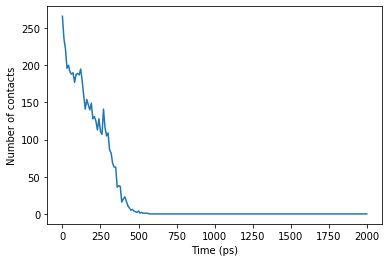

In [15]:
plt.figure()
ax = plt.gca()
ax.plot(contacts_1[:,0], contacts_1[:,1])
ax.set_xlabel("Time (ps)")
ax.set_ylabel("Number of contacts")